In [1]:
import iris
import iris.analysis.stats as istats
import warnings
import matplotlib.pyplot as plt
import numpy as np
import iris.plot as iplt
import cartopy.crs as ccrs
import os
import datetime as dt
import cmocean

In [2]:
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from load_cmip import load_cmip

In [3]:
alpha_w = iris.coords.AuxCoord(1/1000.,units='m**3*kg**-1')
cmip_info = {"ACCESS-CM2":("CSIRO-ARCCSS","r4i1p1f1"),"ACCESS-ESM1-5":('CSIRO','r6i1p1f1'),'NorESM2-MM':('NCC','r1i1p1f1')}
def load_cmip6(scenario,model,stream,var,t_s,t_e,Constraints,template=None,lapse=None,regrid_method=iris.analysis.Linear(),callback=None):
    group,rev  = cmip_info[model]
    if scenario == 'historical':
        mip = "CMIP"
    else:
        mip = "ScenarioMIP"
    path = "/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/{stream}/{var}/gn/latest/".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    filepart = "{var}_{stream}_{model}_{scenario}_{rev}_gn".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    try:
        files = [f for f in os.listdir(path) if filepart in f]
    except:
        path = path.replace('latest','v20191108')
        files = [f for f in os.listdir(path) if filepart in f]
    starts = [f.split("_")[-1].split("-")[0] for f in files]
    ends = [f.split("_")[-1].split("-")[1] for f in files]
    starts = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in starts]
    ends = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in ends]
    files = [ os.path.join(path,f) for (i,f) in enumerate(files) if ((t_e  - starts[i]).days >0  and (ends[i] - t_s).days >= 0) ]
    ct = iris.Constraint(time = lambda t: ((dt.datetime(t.point.year,t.point.month,1) - t_s).days >= 0) and ((dt.datetime(t.point.year,t.point.month,1) - t_e).days < 0))
    data = iris.load(files,Constraints&ct)
    iris.util.equalise_attributes(data)
    data=data.concatenate_cube()
    if not template is None:
        data.coord('longitude').coord_system = template.coord('longitude').coord_system
        data.coord('latitude').coord_system = template.coord('latitude').coord_system
        data = data.regrid(template,regrid_method)
        if lapse is not None:
            topo_CMIP = iris.load_cube("/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/fx/orog/gn/latest/orog_fx_{model}_{scenario}_{rev}_gn.nc".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model),Constraints,callback)
            topo_CMIP.coord('longitude').coord_system = template.coord('longitude').coord_system
            topo_CMIP.coord('latitude').coord_system = template.coord('latitude').coord_system
            topo_CMIP = topo_CMIP.regrid(template,regrid_method)
            delta = (template - topo_CMIP)*lapse
            delta.convert_units(data.units)
            data.data = data.data + delta.data
    if var=='pr':
        name = data.name()
        data = data*alpha_w
        data.rename(name)
    return data

In [4]:
def callback(cube,field,filename):
    cube1 = cube.extract(iris.Constraint(longitude=lambda x: x>=0))
    cube2 = cube.extract(iris.Constraint(longitude=lambda x: x<0))
    cube2.coord('longitude').points = cube2.coord('longitude').points + 360
    if cube2.coord('longitude').has_bounds():
        cube2.coord('longitude').bounds = cube2.coord('longitude').bounds + 360
    return iris.cube.CubeList([cube1,cube2]).concatenate_cube()

In [5]:
prod = {"cg282_ACCESS-CM2_historical_1960_sciB":np.arange(1961,1966),
        "cg282_ACCESS-CM2_ssp126_2014_sciB":np.arange(2016,2020),
        "cg282_ACCESS-CM2_ssp370_2014_sciB":np.arange(2016,2020),
        "cg282_ERA5_historical_1979_sciB":np.arange(1980,1984),
        "cg282_ACCESS-ESM1-5_ssp370_2014_sciB":[2015,2016,2017],
        "cg282_NorESM2-MM_ssp370_2014_sciB":[2014],
        "cg282_NorESM2_2010":[2010]}

cx = iris.Constraint(longitude = lambda x: 90<=x<=200)
cy = iris.Constraint(latitude = lambda x: -50<=x<=10)
ct = iris.Constraint(time = lambda t: t.point.month in range(2,8))

In [6]:
data = {}

for key in prod.keys():
    data[key] = iris.load(["/g/data/tp28/dev/eh6215/comp/%s_sl_%d.nc"%(key,year) for year in prod[key]],ct)
    for cube in data[key]:
        if cube.var_name != 'ttl_col_q':
            if cube.var_name[:9] == 'ttl_col_q':
                cube.var_name = 'ttl_col_q'
            else:
                cube.var_name=None
        cube.coord('time').var_name = None
        cube.coord('forecast_period').var_name = None
    iris.util.equalise_attributes(data[key])
    data[key] = data[key].merge().concatenate()
    for cube in data[key].extract("x_wind"):
        cube.rename('eastward_wind')
    for cube in data[key].extract("y_wind"):
        cube.rename('northward_wind')
    for cube in data[key].extract("air_temperature"):
        cube.rename('2 metre temperature')
    for cube in data[key].extract("ttl_col_q"):
        cube.units = "kg m**-2"
    for cube in data[key].extract("precipitation_flux"):
        cube.units = "mm/s"
        cube.convert_units('mm/day')
        cube.rename('precipitation')
    iris.util.equalise_attributes(data[key])
    data[key] = data[key].merge().concatenate()
    print(data[key])
    

0: ttl_col_q / (kg m**-2)              (time: 30; latitude: 458; longitude: 798)
1: 2 metre temperature / (K)           (time: 30; latitude: 458; longitude: 798)
2: air_pressure_at_sea_level / (Pa)    (time: 30; latitude: 458; longitude: 798)
3: air_temperature_max / (K)           (time: 30; latitude: 458; longitude: 798)
4: air_temperature_min / (K)           (time: 30; latitude: 458; longitude: 798)
5: eastward_wind / (m s-1)             (time: 30; pressure: 3; latitude: 459; longitude: 798)
6: northward_wind / (m s-1)            (time: 30; pressure: 3; latitude: 459; longitude: 798)
7: precipitation / (mm/day)            (time: 30; latitude: 458; longitude: 798)
8: specific_humidity / (1)             (time: 30; pressure: 3; latitude: 459; longitude: 798)
9: toa_outgoing_longwave_flux / (W m-2) (time: 30; latitude: 458; longitude: 798)
0: ttl_col_q / (kg m**-2)              (time: 24; latitude: 458; longitude: 798)
1: 2 metre temperature / (K)           (time: 24; latitude: 458; long

In [8]:
print(cmip6)

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of precipitation / (m.s-1) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of eastward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
<iris 'Cube' of northward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
<iris 'Cube' of specific_humidity / (1) (time: 60; air_pressure: 3; latitude: 50; longitude: 60)>], 'cg282_ACCESS-CM2_ssp126_2014_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 48; latitude: 50; longitude: 60)>,
<iris 'Cube' of 2 metre temperature / (K) (time: 48; latitude: 50; longitude: 60)>,
<iris 'Cube' of precipitat

In [22]:
varlist = {'ttl_col_q':('prw',2),
        '2 metre temperature':('tas',2),
        'precipitation':('pr',2),
        'air_pressure_at_sea_level':('psl',2),
        'toa_outgoing_longwave_flux':('rlut',2),
        'eastward_wind':('ua',3),
        'northward_wind':('va',3),
        'specific_humidity':('hus',3)}

cp =iris.Constraint(air_pressure = lambda p: p in [20000,50000,85000])
#cmip6 = {}
for key in prod:
    if 'ERA5' not in key and key not in cmip6.keys():
        print(key)
        cmip6[key]=iris.cube.CubeList()
        year0 =prod[key][0]
        year1 =prod[key][-1]+1
        model,scen = key.split("_")[1:3]
        if key =="cg282_NorESM2_2010":
            model=model+"-MM"
        scen='historical'
        for var in varlist:
            try:
                if varlist[var][1]==2:
                    cmip6[key].append(load_cmip6(scen,model,"Amon",varlist[var][0],dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,callback=callback))
                if varlist[var][1]==3:
                    cmip6[key].append(load_cmip6(scen,model,"Amon",varlist[var][0],dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy&cp,callback=callback))
                cmip6[key][-1].rename(var)
                if var == 'precipitation':
                    cmip6[key][-1].convert_units("mm/day")
            except FileNotFoundError:
                print(varlist[var])
    


cg282_NorESM2-MM_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'prw'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileform

In [8]:
ref = iris.load("/g/data/tp28/dev/eh6215/comp/era5.nc")
ref.extract("air_pressure_at_mean_sea_level")[0].rename("air_pressure_at_sea_level")
ref.extract("Mean top net long-wave radiation flux")[0].data = ref.extract("Mean top net long-wave radiation flux")[0].data*-1
ref.extract("Mean top net long-wave radiation flux")[0].rename("toa_outgoing_longwave_flux")
ref.extract("lwe_thickness_of_atmosphere_mass_content_of_water_vapor")[0].rename("ttl_col_q")
iris.util.equalise_attributes(ref)
print(ref)
#print(data["cg282_ACCESS-CM2_ssp126_2014_sciB"])

0: toa_outgoing_longwave_flux / (W m**-2) (time: 12; latitude: 241; longitude: 441)
1: 2 metre temperature / (K)           (time: 12; latitude: 241; longitude: 441)
2: air_pressure_at_sea_level / (Pa)    (time: 12; latitude: 241; longitude: 441)
3: air_temperature / (K)               (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
4: eastward_wind / (m s**-1)           (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
5: ttl_col_q / (kg m**-2)              (time: 12; latitude: 241; longitude: 441)
6: northward_wind / (m s**-1)          (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
7: specific_humidity / (kg kg**-1)     (time: 12; pressure_level: 3; latitude: 241; longitude: 441)


In [9]:
precip = iris.load_cube("/g/data/tp28/dev/eh6215/comp/gpcp.nc",'precip').extract(cx&cy)
precip.coord('time').points = [18993.-365, 19024.-365, 18687., 18718., 18748., 18779., 18809., 18840., 18871., 18901., 18932., 18962.]
precip.coord('time').bounds=None
iris.util.promote_aux_coord_to_dim_coord(precip,'time')
precip.rename('precipitation')
print(precip.summary(shorten=True))
ref.append(precip)

precipitation / (mm/day)            (time: 12; latitude: 26; longitude: 46)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:874: UserWarning: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name), error=e_msg))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:874: UserWarning: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name), error=e_msg))


AMIP validation variables are: 

PMSL global 

Precip land - bands (DJF, MAM, JJA, SON) 

Precip ocean - bands (DJF, MAM, JJA, SON) 

Precipitable water (DJF,JJA) 

1.5m mean temperature (DJF,JJA) 

200 hPa horizontal wind (DJF, JJA) 

850 hPa horizontal wind (DJF, JJA) 

zonal mean U wind (DJF, JJA) 

zonal mean V wind (DJF, JJA) 


In [113]:
vars = ['air_pressure_at_sea_level', '2 metre temperature', 'toa_outgoing_longwave_flux', 'eastward_wind', 'northward_wind', 'specific_humidity', 'ttl_col_q']

corrs = {}
bias  = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for var in vars:
        print(var)
        r = ref.extract_cube(var)[:12].collapsed('time',iris.analysis.MEAN)
        if r.ndim==2:
            corrs[var],bias[var] = {},{}
        else:
            for p in ['200','500','850']:
                corrs[var+p],bias[var+p] = {},{}
        for key in prod:
            d = data[key].extract_cube(var).collapsed('time',iris.analysis.MEAN)
            r=r.regrid(d,iris.analysis.Linear())
            if r.ndim == 2:
                corrs[var][key] = iris.analysis.stats.pearsonr(r,d,['longitude','latitude']).data
                bias[var][key] = ((r - d).collapsed(['longitude','latitude'],iris.analysis.MEAN)/r.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
            else:
                for p in [200,500,850]:
                    rr = r.extract(iris.Constraint(pressure_level = p) )#.collapsed('time',iris.analysis.MEAN)
                    dd = d.extract(iris.Constraint(pressure = p) )#.collapsed('time',iris.analysis.MEAN)
                    corrs["%s%d"%(var,p)][key] = iris.analysis.stats.pearsonr(rr,dd,['longitude','latitude']).data
                    bias["%s%d"%(var,p)][key] = ((rr - dd).collapsed(['longitude','latitude'],iris.analysis.MEAN)/rr.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data

air_pressure_at_sea_level
2 metre temperature
toa_outgoing_longwave_flux
eastward_wind
northward_wind
specific_humidity
ttl_col_q


In [104]:
vars = ['air_pressure_at_sea_level', '2 metre temperature', 'toa_outgoing_longwave_flux', 'eastward_wind', 'northward_wind', 'specific_humidity', 'ttl_col_q']
print('h')
corrs_cmip = {}
bias_cmip  = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for var in vars:
        print(var)
        r = ref.extract_cube(var)[:12].collapsed('time',iris.analysis.MEAN)
        if r.ndim==2:
            corrs_cmip[var],bias_cmip[var] = {},{}
        else:
            for p in ['200','500','850']:
                corrs_cmip[var+p],bias_cmip[var+p] = {},{}
        for key in prod:
            if 'ERA5' not in key:
                try:
                    d = cmip6[key].extract_cube(var).collapsed('time',iris.analysis.MEAN)
                    r=r.regrid(d,iris.analysis.Linear())
                    if r.ndim == 2:
                        corrs_cmip[var][key] = iris.analysis.stats.pearsonr(r,d,['longitude','latitude']).data
                        bias_cmip[var][key] = ((r - d).collapsed(['longitude','latitude'],iris.analysis.MEAN)/r.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
                    else:
                        for p in [200,500,850]:
                            rr = r.extract(iris.Constraint(pressure_level = p) )#.collapsed('time',iris.analysis.MEAN)
                            dd = d.extract(iris.Constraint(air_pressure = p*100) )#.collapsed('time',iris.analysis.MEAN)
                            corrs_cmip["%s%d"%(var,p)][key] = iris.analysis.stats.pearsonr(rr,dd,['longitude','latitude']).data
                            bias_cmip["%s%d"%(var,p)][key] = ((rr - dd).collapsed(['longitude','latitude'],iris.analysis.MEAN)/rr.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
                except:
                    continue

h
air_pressure_at_sea_level
2 metre temperature
toa_outgoing_longwave_flux
eastward_wind
northward_wind
specific_humidity
ttl_col_q


In [136]:
print(bias)


{'air_pressure_at_sea_level': {'cg282_ACCESS-CM2_historical_1960_sciB': array(0.14013486), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.00584763), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(0.07239914), 'cg282_ERA5_historical_1979_sciB': array(0.08795635)}, '2 metre temperature': {'cg282_ACCESS-CM2_historical_1960_sciB': array(-0.05880315), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.15209166), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(-0.1373221), 'cg282_ERA5_historical_1979_sciB': array(-0.00900691)}, 'toa_outgoing_longwave_flux': {'cg282_ACCESS-CM2_historical_1960_sciB': array(0.2303065), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(0.19185334), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(0.18016832), 'cg282_ERA5_historical_1979_sciB': array(0.13563256)}, 'eastward_wind200': {'cg282_ACCESS-CM2_historical_1960_sciB': array(-0.09276623), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.11379208), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(-0.10386606), 'cg282_ERA5_historical_1979_sciB':

Text(0.5, 1.0, 'barpa correlation')

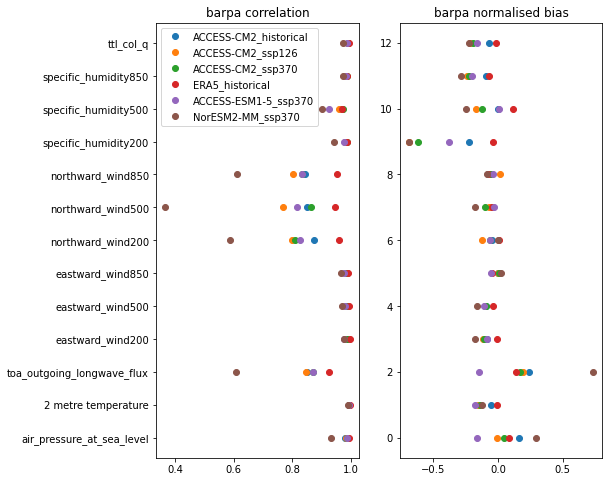

In [117]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('barpa correlation')
ax2.set_title('barpa normalised bias')

c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for j,var in enumerate(list(corrs.keys())):
    for i,key in enumerate(prod):
        if j==0:
            ax1.plot([corrs[var][key]],[j],'o',c=c[i],label=key[6:-10])
        else:
            ax1.plot([corrs[var][key]],[j],'o',c=c[i])
        ax2.plot([bias[var][key]],[j],'o',c=c[i])

ax1.legend()
ax1.set_yticks(np.arange(0,len(corrs)))
ax1.set_yticklabels(list(corrs.keys()))
ax1.title

Text(0.5, 1.0, 'cmip6 correlation')

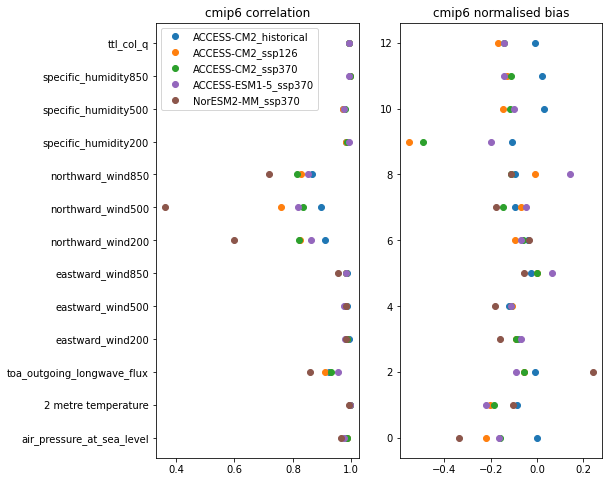

In [118]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.set_title('cmip6 correlation')
ax2.set_title('cmip6 normalised bias')
c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for j,var in enumerate(list(corrs_cmip.keys())):
    for i,key in enumerate(prod):
        if 'ERA5' not in key:
            if j==0:
                ax1.plot([corrs_cmip[var][key]],[j],'o',c=c[i],label=key[6:-10])
            else:
                try:
                    ax1.plot([corrs_cmip[var][key]],[j],'o',c=c[i])
                except KeyError:
                    continue
            ax2.plot([bias_cmip[var][key]],[j],'o',c=c[i])

ax1.legend()
ax1.set_yticks(np.arange(0,len(corrs_cmip)))
ax1.set_yticklabels(list(corrs_cmip.keys()))
ax1.title

In [11]:
plot_properties = {'toa_outgoing_longwave_flux':(150,300,100,'binary','bwr'),
                  '2 metre temperature':(280,307,3,'hot_r','bwr'),
                  'eastward_wind850':(-30,30,5,'PiYG','PiYG'),
                  'northward_wind850':(-8,8,4,'PiYG','PiYG'),
                   'ttl_col_q':(0,60,20,cmocean.cm.rain,'BrBG'),
                   'air_pressure_at_sea_level':(99000,103000,1000,'viridis','BrBG'),
                   'precipitation':(0,30,10,cmocean.cm.rain,'BrBG')
                  }

precipitation
2 metre temperature


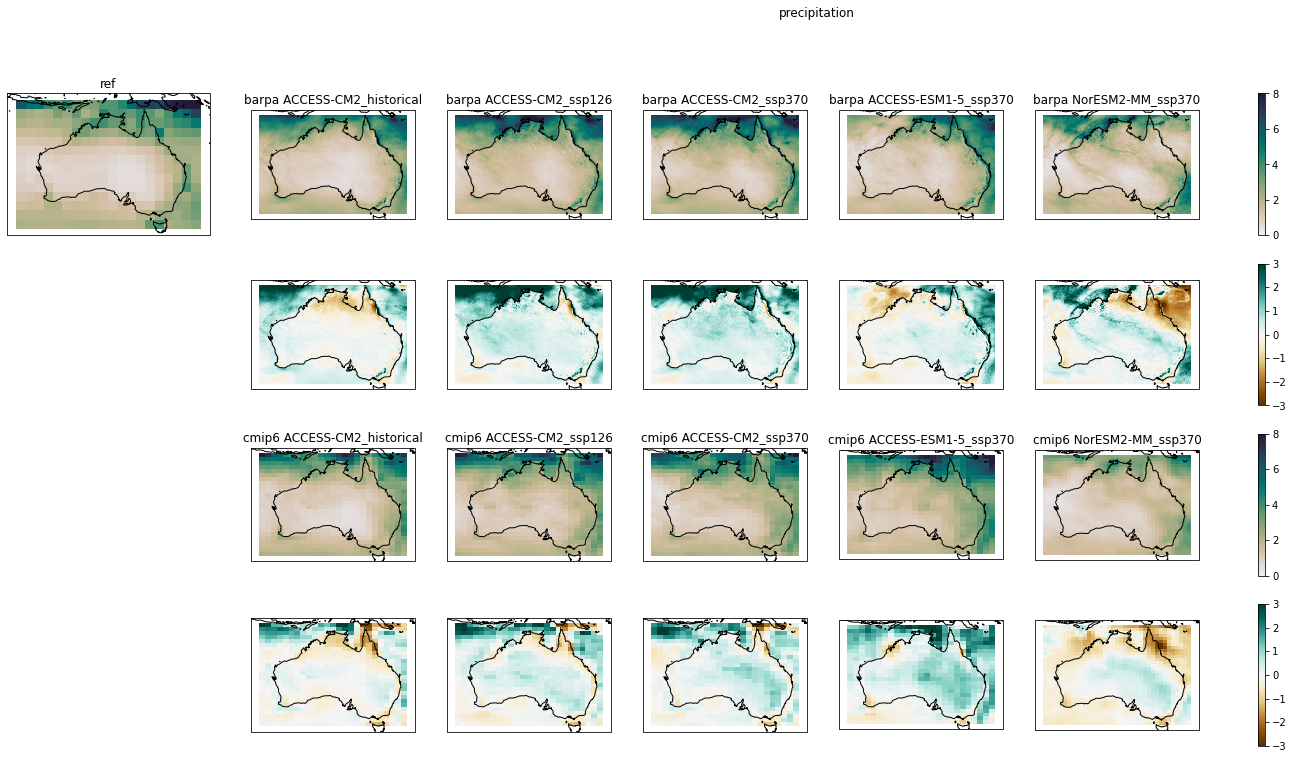

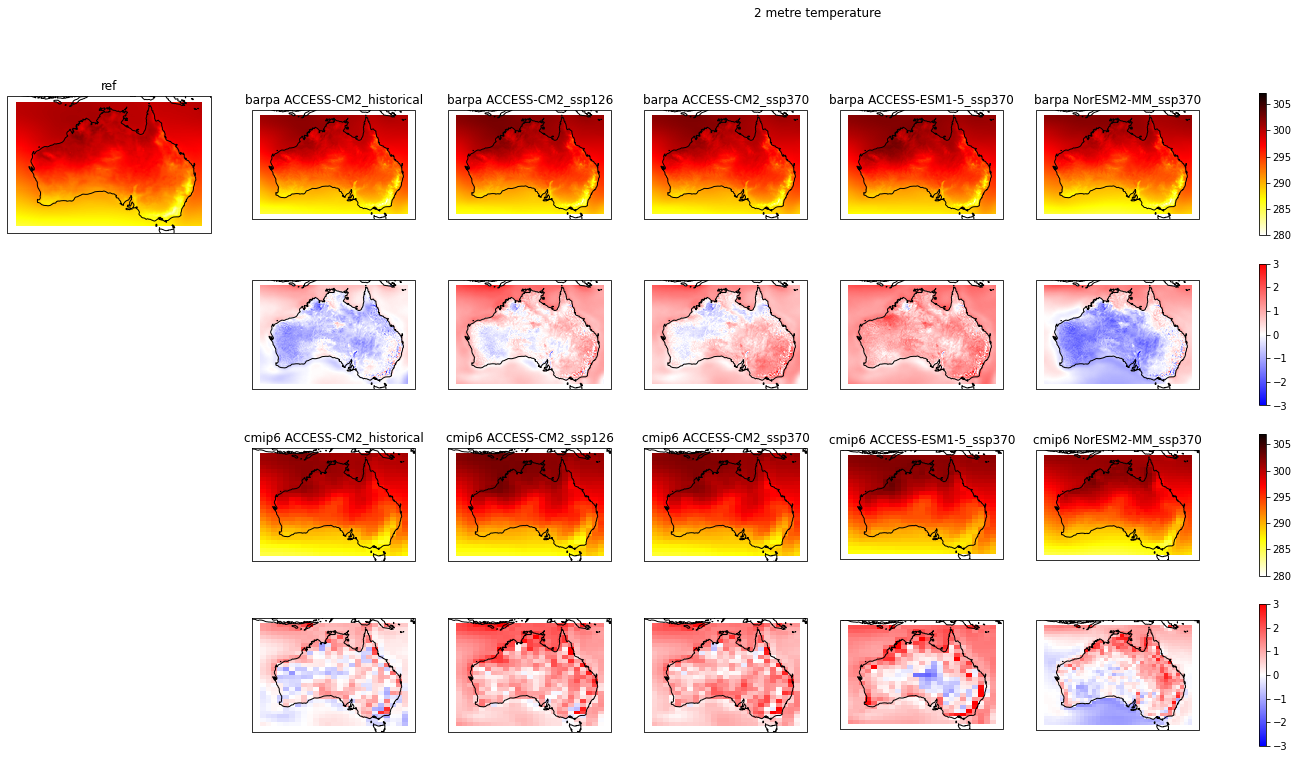

In [50]:
cx2 = iris.Constraint(longitude=lambda x: 110<=x<=155)
cy2 = iris.Constraint(latitude =lambda y:-40<=y<=-10)
#for var,p in [('toa_outgoing_longwave_flux',""),('2 metre temperature',""),('precipitation',"")]:
for var,p in [('precipitation',""),('2 metre temperature','')]:
    vmin,vmax,vdiff,cmap1,cmap2=plot_properties[var+p]
    n = len(prod)
    fig=plt.figure(figsize=(30,12))
    plt.suptitle(var)
    axs1,axs2,axs3,axs4=[],[],[],[]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        print(var)
        r = ref.extract_cube(var).collapsed('time',iris.analysis.MEAN)
        ax=plt.subplot(4,n+1,1,projection=ccrs.PlateCarree(180))
        if r.ndim==3:
            r = r.extract(iris.Constraint(pressure_level = int(p)) )#.collapsed('time',iris.analysis.MEAN)            
        iplt.pcolormesh(r.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
        plt.title("ref")
        ax.coastlines()
        for i,key in enumerate([key for key in prod if 'ERA5' not in key]):
            d = data[key].extract_cube(var)[:].collapsed('time',iris.analysis.MEAN)
            c = cmip6[key].extract_cube(var)[:].collapsed('time',iris.analysis.MEAN)
            rc=r.regrid(c,iris.analysis.Linear())
            r=r.regrid(d,iris.analysis.Linear())
            if d.ndim == 3:
                d = d.extract(iris.Constraint(pressure = int(p)) )
                c = c.extract(iris.Constraint(air_pressure = int(p)*100) )
            axs1.append(plt.subplot(4,n+1,i+2,projection=ccrs.PlateCarree(180)))
            a1=iplt.pcolormesh(d.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
            plt.title('barpa '+key[6:-10])
            axs1[-1].coastlines()
            axs2.append(plt.subplot(4,n+1,i+2+1*(n+1),projection=ccrs.PlateCarree(180)))
            a2=iplt.pcolormesh((d-r).extract(cx2&cy2),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs2[-1].coastlines()
            axs3.append(plt.subplot(4,n+1,i+2+2*(n+1),projection=ccrs.PlateCarree(180)))
            a3=iplt.pcolormesh(c.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
            axs3[-1].coastlines()
            plt.title('cmip6 '+key[6:-10])
            axs4.append(plt.subplot(4,n+1,i+2+3*(n+1),projection=ccrs.PlateCarree(180)))
            a4=iplt.pcolormesh((c-rc).extract(cx2&cy2),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs4[-1].coastlines()
    fig.colorbar(a1,ax=axs1)
    fig.colorbar(a2,ax=axs2)
    fig.colorbar(a3,ax=axs3)
    fig.colorbar(a4,ax=axs4)

2 metre temperature


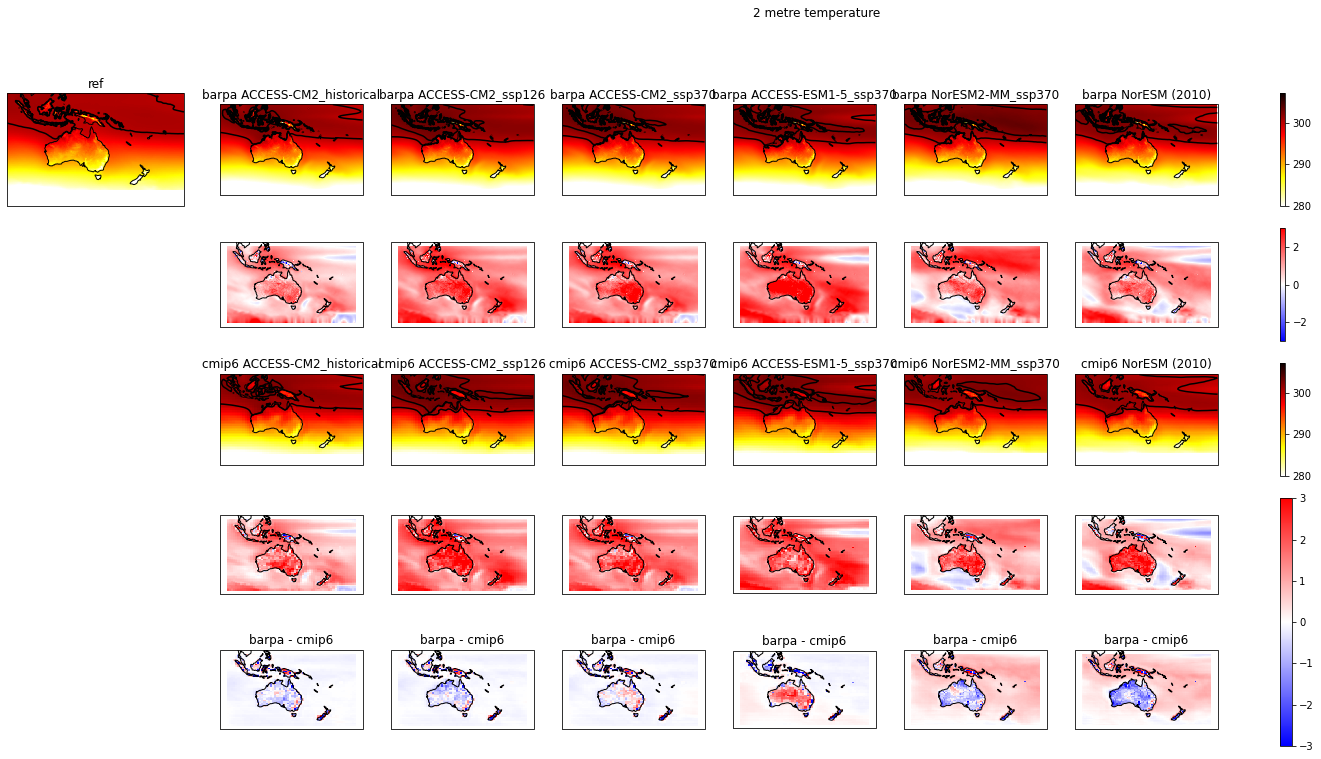

In [25]:
cx2 = iris.Constraint(longitude=lambda x: 90<=x<=200)
cy2 = iris.Constraint(latitude =lambda y:-60<=y<=10)
for var,p in [('2 metre temperature',"")]:
#for var,p in [('toa_outgoing_longwave_flux',""),('2 metre temperature',""),('air_pressure_at_sea_level',''),('eastward_wind','850'),('northward_wind','850'),('precipitation',""),]:
    vmin,vmax,vdiff,cmap1,cmap2=plot_properties[var+p]
    n = len(prod)
    fig=plt.figure(figsize=(30,12))
    plt.suptitle(var)
    axs1,axs2,axs3,axs4=[],[],[],[]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        print(var)
        r = ref.extract_cube(var).extract(ct).collapsed('time',iris.analysis.MEAN)
        ax=plt.subplot(5,n+1,1,projection=ccrs.PlateCarree(180))
        if r.ndim==3:
            r = r.extract(iris.Constraint(pressure_level = int(p)) )#.collapsed('time',iris.analysis.MEAN)            
        iplt.pcolormesh(r.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
        iplt.contour(r.extract(cx2&cy2),[300,302],colors='k')
        plt.title("ref")
        ax.coastlines()
        plt.xlim(-90,20)
        plt.ylim(-60,10)
        for i,key in enumerate([key for key in prod if 'ERA5' not in key]):
            d = data[key].extract_cube(var).collapsed('time',iris.analysis.MEAN)
            c = cmip6[key].extract_cube(var).extract(ct).collapsed('time',iris.analysis.MEAN)
            rc=r.regrid(c,iris.analysis.Linear())
            r=r.regrid(d,iris.analysis.Linear())
            if d.ndim == 3:
                d = d.extract(iris.Constraint(pressure = int(p)) )
                c = c.extract(iris.Constraint(air_pressure = int(p)*100) )
            dc=d.regrid(c,iris.analysis.Linear())
            axs1.append(plt.subplot(5,n+1,i+2,projection=ccrs.PlateCarree(180)))
            a1=iplt.pcolormesh(d.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
            iplt.contour(d.extract(cx2&cy2),[300,302],colors='k')
            plt.xlim(-90,20)
            plt.ylim(-60,10)
            if i == 5:
                plt.title('barpa NorESM (2010)')
            else:
                plt.title('barpa '+key[6:-10])
            axs1[-1].coastlines()
            axs2.append(plt.subplot(5,n+1,i+2+1*(n+1),projection=ccrs.PlateCarree(180)))
            a2=iplt.pcolormesh((d-r).extract(cx2&cy2),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs2[-1].coastlines()
            axs3.append(plt.subplot(5,n+1,i+2+2*(n+1),projection=ccrs.PlateCarree(180)))
            a3=iplt.pcolormesh(c.extract(cx2&cy2),vmin=vmin,vmax=vmax,cmap=cmap1)
            iplt.contour(c.extract(cx2&cy2),[300,302],colors='k')
            axs3[-1].coastlines()
            plt.xlim(-90,20)
            plt.ylim(-60,10)
            if i == 5:
                plt.title('cmip6 NorESM (2010)')
            else:
                plt.title('cmip6 '+key[6:-10])
            axs4.append(plt.subplot(5,n+1,i+2+3*(n+1),projection=ccrs.PlateCarree(180)))
            a4=iplt.pcolormesh((c-rc).extract(cx2&cy2),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs4[-1].coastlines()
            axs4.append(plt.subplot(5,n+1,i+2+4*(n+1),projection=ccrs.PlateCarree(180)))
            plt.title('barpa - cmip6')
            a4=iplt.pcolormesh((dc-c).extract(cx2&cy2),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs4[-1].coastlines()
    fig.colorbar(a1,ax=axs1)
    fig.colorbar(a2,ax=axs2)
    fig.colorbar(a3,ax=axs3)
    fig.colorbar(a4,ax=axs4)

In [80]:
print(cmip6['cg282_ACCESS-CM2_historical_1960_sciB'].extract('eastward_wind')[0].coord('air_pressure'))

DimCoord(array([1000.,  500.,  100.]), bounds=array([[1500.,  750.],
       [ 750.,  300.],
       [ 300., -100.]]), standard_name='air_pressure', units=Unit('Pa'), long_name='pressure', var_name='plev', attributes={'positive': 'down'})


In [103]:
1

1

In [8]:
cx2=iris.Constraint(longitude=lambda x:160<=x<=200)
cy2=iris.Constraint(latitude=lambda y:-15<=y<=15)

Te = iris.load(["/g/data/rt52/era5/single-levels/monthly-averaged/sst/%04d/*.nc"%year for year in range(1979,2022)],cx2&cy2)
Pe = iris.load(["/g/data/rt52/era5/single-levels/monthly-averaged/mtpr/%04d/*.nc"%year for year in range(1979,2022)],cx2&cy2)

In [9]:
iris.util.equalise_attributes(Te)
Te=Te.concatenate_cube()
iris.util.equalise_attributes(Pe)
Pe=Pe.concatenate_cube()
print(Pe)

Mean total precipitation rate / (kg m**-2 s**-1) (time: 516; latitude: 121; longitude: 80)
    Dimension coordinates:
        time                                          x              -               -
        latitude                                      -              x               -
        longitude                                     -              -               x
    Attributes:
        Conventions                              CF-1.6
        license                                  Licence to use Copernicus Products: https://apps.ecmwf.int/datasets/li...
        summary                                  ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats

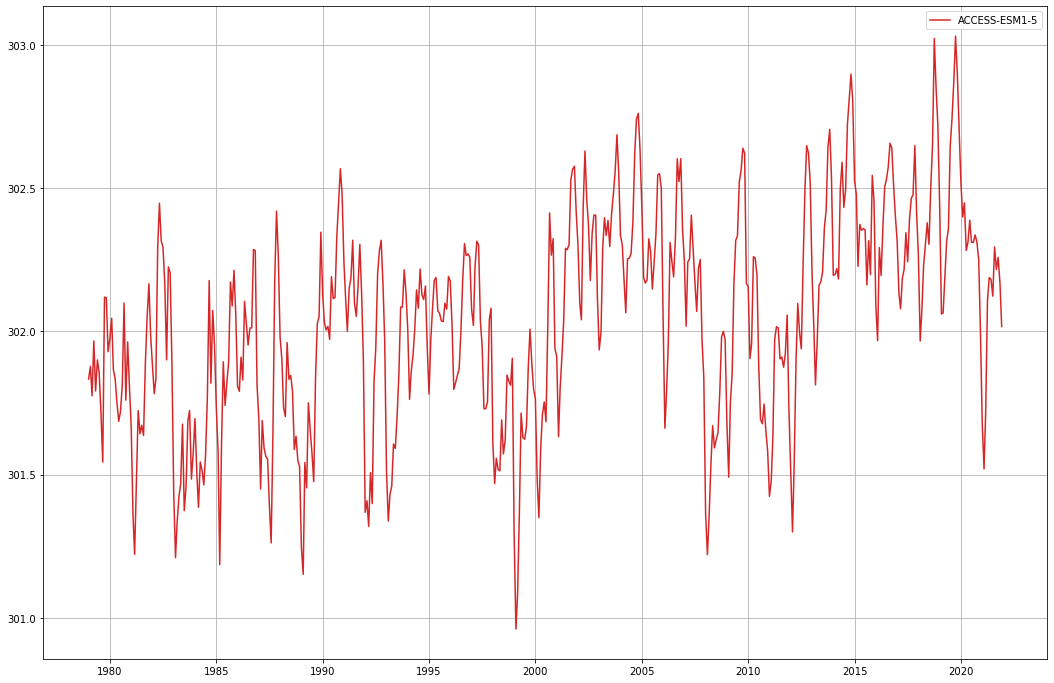

In [41]:
from iris.coord_categorisation  import add_year
c = ['tab:blue','tab:green','tab:orange','tab:red']
plt.figure(figsize=(18,12))
T = {}
P = {}
for i,model in enumerate(["NorESM2-MM","ACCESS-CM2","ACCESS-ESM1-5"]):
        for scen in ['ssp370','historical']:
            T[model+scen] = load_cmip6(scen,model,"Amon","ts",dt.datetime(1960,1,1),dt.datetime(2035,1,1),cx2&cy2,callback=callback)
            P[model+scen] = load_cmip6(scen,model,"Amon","pr",dt.datetime(1960,1,1),dt.datetime(2035,1,1),cx2&cy2,callback=callback)
            #add_year(Tn,'time','year')
            #Tn= Tn.aggregated_by('year',iris.analysis.MEAN)
            #iplt.plot(Tn.collapsed(['latitude','longitude'],iris.analysis.MEAN),label=model,c=c[i])

iplt.plot(Te.collapsed(['latitude','longitude'],iris.analysis.MEAN),label=model,c=c[-1])
plt.grid()
plt.legend()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinat

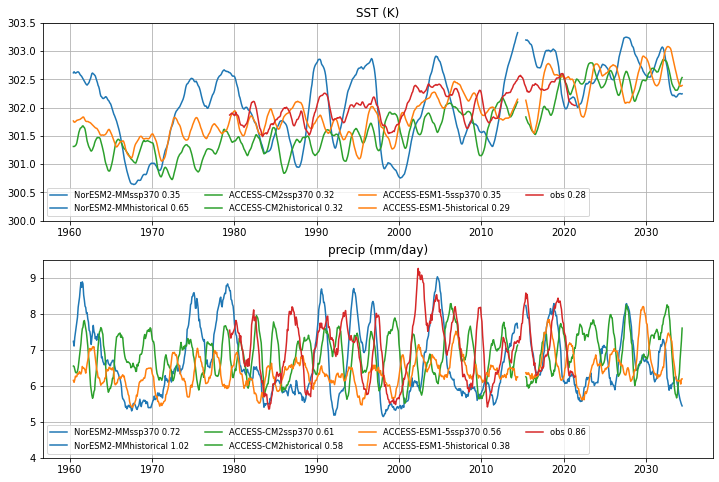

In [42]:
time = {'ssp370':np.arange(2015,2035,1/12),'historical':np.arange(1960,2015,1/12),'era5':np.arange(1979,2022,1/12)}

fig=plt.figure(figsize=(12,8))
plt.subplot(211)
for i,model in enumerate(["NorESM2-MM","ACCESS-CM2","ACCESS-ESM1-5"]):
        for scen in ['ssp370','historical']:
            #add_year(Tn,'time','year')
            #Tn= Tn.aggregated_by('year',iris.analysis.MEAN)
            std=(T[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data).std(ddof=1)
            plt.plot(time[scen][5:-6],T[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data,label=model+scen+" %0.2f"%(std),c=c[i])
std=(Te.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data).std(ddof=1)
plt.plot(time['era5'][5:-6],Te.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data,label="obs %0.2f"%(std),c=c[-1])
plt.grid()
plt.title('SST (K)')
plt.ylim(300,303.5)
plt.legend(fontsize='small',ncol=4)
plt.subplot(212)

time = {'ssp370':np.arange(2015,2035,1/12),'historical':np.arange(1960,2015,1/12),'era5':np.arange(1979,2022,1/12)}

for i,model in enumerate(["NorESM2-MM","ACCESS-CM2","ACCESS-ESM1-5"]):
        for scen in ['ssp370','historical']:
            #add_year(Tn,'time','year')
            #Tn= Tn.aggregated_by('year',iris.analysis.MEAN)
            std=(P[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data).std(ddof=1)*1000*86400
           # correl=float(iris.analysis.stats.pearsonr(T[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN),P[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN),'time').data)
            plt.plot(time[scen][5:-6],1000*86400*P[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data,label=model+scen+" %0.2f"%(std),c=c[i])

std=(Pe.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data).std(ddof=1)*86400
#correl=float(iris.analysis.stats.pearsonr(Te.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),Pe.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),'time').data)
plt.plot(time['era5'][5:-6],86400*Pe.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12).data,label="obs %0.2f"%(std),c=c[-1])
plt.grid()
plt.title('precip (mm/day)')
plt.ylim(4,9.5)
plt.legend(fontsize='small',ncol=4)

In [15]:
P

{'NorESM2-MMssp370': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 240; latitude: 32; longitude: 33)>,
 'NorESM2-MMhistorical': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 540; latitude: 32; longitude: 33)>,
 'ACCESS-CM2ssp370': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 240; latitude: 26; longitude: 22)>,
 'ACCESS-CM2historical': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 540; latitude: 26; longitude: 22)>,
 'ACCESS-ESM1-5ssp370': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 240; latitude: 25; longitude: 23)>,
 'ACCESS-ESM1-5historical': <iris 'Cube' of precipitation_flux / (m.s-1) (time: 540; latitude: 25; longitude: 23)>}

In [27]:
correl=float(iris.analysis.stats.pearsonr(Te.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),Pe.collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),'time').data)
correl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib

0.6116678472279339

In [30]:
for i,model in enumerate(["NorESM2-MM"]):#,"ACCESS-CM2","ACCESS-ESM1-5"]):
        for scen in ['ssp370','historical']:
            correl=float(iris.analysis.stats.pearsonr(T[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),P[model+scen].collapsed(['latitude','longitude'],iris.analysis.MEAN).rolling_window('time',iris.analysis.MEAN,12),'time').data)
            print(correl)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguou

0.8325217924832442


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


0.8721522194254161


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3998: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [29]:
print(correl)

0.8721522194254161


In [13]:
from iris.coord_categorisation import add_month
cx2 = iris.Constraint(longitude=lambda x: 90<=x<=200)
cy2 = iris.Constraint(latitude =lambda y:-60<=y<=10)
for var,p in [('air_pressure_at_sea_level','')]:
    vmin,vmax,vdiff,cmap1,cmap2=plot_properties[var+p]
    n = len(prod)
    fig=plt.figure(figsize=(30,12))
    plt.suptitle(var)
    axs1,axs2,axs3,axs4=[],[],[],[]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        print(var)
        r = ref.extract_cube(var)#.collapsed('time',iris.analysis.MEAN)
        if 'month' not in [c.name() for c in r.coords()]:
            add_month(r,'time','month')
        r = r.aggregated_by('month',iris.analysis.MEAN)
        print(r.coord('month'))
        if r.ndim==4:
            r = r.extract(iris.Constraint(pressure_level = int(p)) )#.collapsed('time',iris.analysis.MEAN)            
        for i,key in enumerate([key for key in prod if 'ERA5' not in key]):
            d = data[key].extract_cube(var)[:]
            if 'month' not in [c.name() for c in d.coords()]: 
                add_month(d,'time','month')
            d = d.aggregated_by('month',iris.analysis.MEAN)
            print(d.coord('month'))
            cc = cmip6[key].extract_cube(var)[:]
            if 'month' not in [c.name() for c in cc.coords() ]:
                add_month(cc,'time','month')
            cc = cc.aggregated_by('month',iris.analysis.MEAN)
            print(cc.coord('month'))
            rc=r.regrid(cc,iris.analysis.Linear())
            r=r.regrid(d,iris.analysis.Linear())
            if d.ndim == 4:
                d = d.extract(iris.Constraint(pressure = int(p)) )
                cc = cc.extract(iris.Constraint(air_pressure = int(p)*100) )
            axs1.append(plt.subplot(2,n,i+1,projection=ccrs.PlateCarree(180)))
            a1=iplt.pcolormesh(iris.analysis.stats.pearsonr(d,r,'month'),vmin=vmin,vmax=vmax,cmap=cmap1)
            plt.title('barpa '+key[6:-10])
            axs1[-1].coastlines()
            plt.title('cmip6 '+key[6:-10])
            axs4.append(plt.subplot(2,n,i+1+n,projection=ccrs.PlateCarree(180)))
            a4=iplt.pcolormesh(iris.analysis.stats.pearsonr(cc,rc,'month'),vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs4[-1].coastlines()
    fig.colorbar(a1,ax=axs1)
    fig.colorbar(a2,ax=axs2)
    fig.colorbar(a3,ax=axs3)
    fig.colorbar(a4,ax=axs4)

NameError: name 'plot_properties' is not defined

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

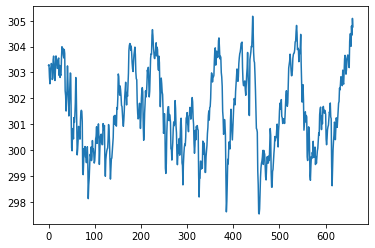

In [68]:
plt.plot(T['NorESM2-MMhistorical'].data[:,16,15].T)
plt.colorbar()

In [70]:
N = load_cmip6('historical','NorESM2-MM',"Omon","tos",dt.datetime(1960,1,1),dt.datetime(2035,1,1),iris.Constraint(time=lambda t:t.point.month==1),callback=callback)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/filefor

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'cell index along first dimension' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'cell index along second dimension' is not bounded, guessing contiguous bounds.
  warnings.warn(


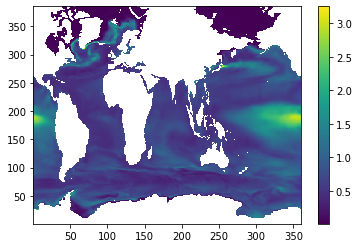

In [76]:
#plt.subplot(111,projection=ccrs.PlateCarree(180))
iplt.pcolormesh(N.collapsed('time',iris.analysis.STD_DEV))
pl
plt.colorbar()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/c

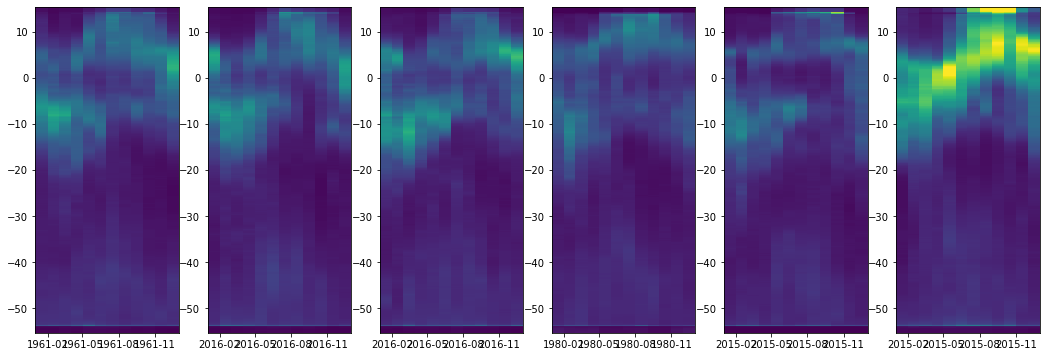

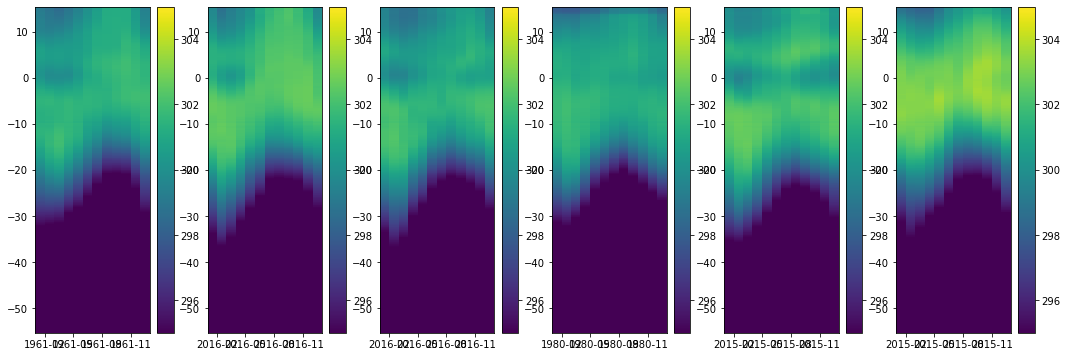

In [31]:
plt.figure(figsize=(18,6))
for i,model in enumerate(prod):
    plt.subplot(1,6,i+1)
    iplt.pcolormesh(data[model].extract('precipitation')[0][:12].collapsed('longitude',iris.analysis.MEAN),vmin=0,vmax=30)
plt.figure(figsize=(18,6))
cx3=iris.Constraint(longitude=lambda x:160<=x<=200)
for i,model in enumerate(prod):
    plt.subplot(1,6,i+1)
    iplt.pcolormesh(data[model].extract(cx3).extract('2 metre temperature')[0][:12].collapsed('longitude',iris.analysis.MEAN),vmin=295,vmax=305)
    plt.colorbar()
    

In [20]:
data

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m**-2) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_max / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_min / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of eastward_wind / (m s-1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of northward_wind / (m s-1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of precipitation / (mm/day) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of specific_humidity / (1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 458; longitude: 798)>],
 'cg282_ACCESS-CM2_ssp126_2014_sciB': [

In [33]:
P = [data['cg282_NorESM2-MM_ssp370_2014_sciB'].extract("air_pressure_at_sea_level")[0]] + [data['cg282_NorESM2-MM_ssp370_2014_sciB'].extract("air_pressure_at_sea_level")[1][i] for i in range(11)]+[data['cg282_NorESM2-MM_ssp370_2014_sciB'].extract("air_pressure_at_sea_level")[2][i] for i in range(12)]
for cube in P:
    cube.coord('latitude').var_name=None
    cube.coord('longitude').var_name=None
    
P = iris.cube.CubeList(P).merge()
data

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m**-2) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_max / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_min / (K) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of eastward_wind / (m s-1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of northward_wind / (m s-1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of precipitation / (mm/day) (time: 60; latitude: 458; longitude: 798)>,
 <iris 'Cube' of specific_humidity / (1) (time: 60; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 458; longitude: 798)>],
 'cg282_ACCESS-CM2_ssp126_2014_sciB': [

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib

ValueError: Cube must be 1-dimensional. Got 0 dimensions.

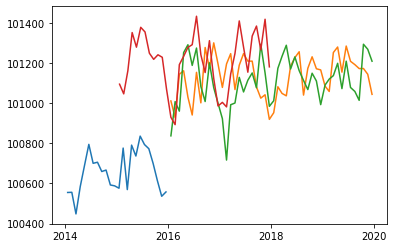

In [35]:
cx = iris.Constraint(longitude=lambda x: 160<=x<=200)
cy = iris.Constraint(latitude=lambda x: -20<=x<=20)
iplt.plot(P.extract(cx&cy)[0].collapsed(['latitude','longitude'],iris.analysis.MEAN))

for var in data:
    if 'ssp' in var:
        iplt.plot(data[var].extract("air_pressure_at_sea_level")[0].collapsed(['latitude','longitude'],iris.analysis.MEAN))

In [39]:
cmip6["cg282_NorESM2_2010"] = cmip6["cg282_NorESM2-MM_ssp370_2014_sciB"]

In [20]:
data.keys()

dict_keys(['cg282_NorESM2-MM_ssp370_2014_sciB'])

In [29]:
n

7

In [59]:
cmip6.keys()

dict_keys(['cg282_ACCESS-CM2_historical_1960_sciB', 'cg282_ACCESS-CM2_ssp126_2014_sciB', 'cg282_ACCESS-CM2_ssp370_2014_sciB', 'cg282_ACCESS-ESM1-5_ssp370_2014_sciB', 'cg282_NorESM2-MM_ssp370_2014_sciB'])

In [58]:
cmip6.pop('cg282_NorESM2_2010_sl')

[<iris 'Cube' of 2 metre temperature / (K) (time: 12; latitude: 65; longitude: 89)>,
<iris 'Cube' of precipitation / (mm/day) (time: 12; latitude: 65; longitude: 89)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 12; latitude: 65; longitude: 89)>,
<iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 12; latitude: 65; longitude: 89)>,
<iris 'Cube' of eastward_wind / (m s-1) (time: 12; air_pressure: 3; latitude: 65; longitude: 89)>,
<iris 'Cube' of northward_wind / (m s-1) (time: 12; air_pressure: 3; latitude: 65; longitude: 89)>,
<iris 'Cube' of specific_humidity / (1) (time: 12; air_pressure: 3; latitude: 65; longitude: 89)>]

In [56]:
cmip6

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of precipitation / (mm/day) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of eastward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
 <iris 'Cube' of northward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
 <iris 'Cube' of specific_humidity / (1) (time: 60; air_pressure: 3; latitude: 50; longitude: 60)>],
 'cg282_ACCESS-CM2_ssp126_2014_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 48; latitude: 50; longitude: 60)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 48; latitude: 50; longitude: 60)>,
 <iris 'Cube' of

In [17]:
data

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m**-2) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_max / (K) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of air_temperature_min / (K) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of eastward_wind / (m s-1) (time: 30; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of northward_wind / (m s-1) (time: 30; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of precipitation / (mm/day) (time: 30; latitude: 458; longitude: 798)>,
 <iris 'Cube' of specific_humidity / (1) (time: 30; pressure: 3; latitude: 459; longitude: 798)>,
 <iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 30; latitude: 458; longitude: 798)>],
 'cg282_ACCESS-CM2_ssp126_2014_sciB': [

In [18]:
cmip6

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of precipitation / (mm/day) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 50; longitude: 60)>,
 <iris 'Cube' of eastward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
 <iris 'Cube' of northward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
 <iris 'Cube' of specific_humidity / (1) (time: 60; air_pressure: 3; latitude: 50; longitude: 60)>],
 'cg282_ACCESS-CM2_ssp126_2014_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 48; latitude: 50; longitude: 60)>,
 <iris 'Cube' of 2 metre temperature / (K) (time: 48; latitude: 50; longitude: 60)>,
 <iris 'Cube' of

In [21]:
cmip6.pop('cg282_NorESM2-MM_ssp370_2014_sciB')

[]